In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [84]:
df= pd.read_csv('data/salary.csv')
df.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
0,53000.0,0,0,0,1.17,1,0,1,1,3,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2
3,35782.0,0,2,1,0.99,1,0,1,1,4,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1


## 1. Split the data

In [85]:
X= df.drop('salary', axis=1)
y= df.salary

In [86]:
print(f'X takes the shape {X.shape}')
print(f'y takes the shape {y.shape}')

X takes the shape (514, 10)
y takes the shape (514,)


In [87]:
# Training and testing data
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3)

train= df[:int(len(df)*0.7)]
test= df[int(len(df)*0.3):]

train.shape

(359, 11)

In [88]:
train.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
0,53000.0,0,0,0,1.17,1,0,1,1,3,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2
3,35782.0,0,2,1,0.99,1,0,1,1,4,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1


In [89]:
# missing values
train.isnull().sum()

salary         1
exprior        0
yearsworked    0
yearsrank      0
market         0
degree         0
otherqual      0
position       0
male           0
Field          0
yearsabs       0
dtype: int64

In [90]:
salary_mean= train.salary.mean()
train.salary.fillna(salary_mean, inplace=True)

/home/masai/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


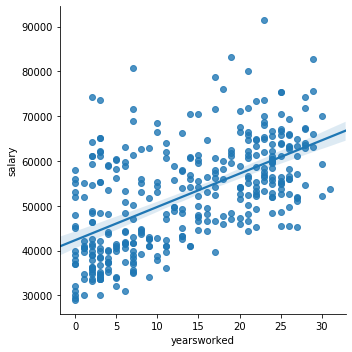

In [91]:
sns.lmplot(x='yearsworked',y='salary',data=train)

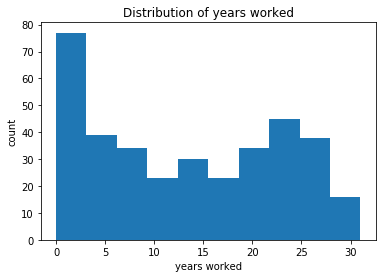

In [92]:
plt.hist(train.yearsworked)
plt.title('Distribution of years worked')
plt.xlabel('years worked')
plt.ylabel('count')
plt.show()

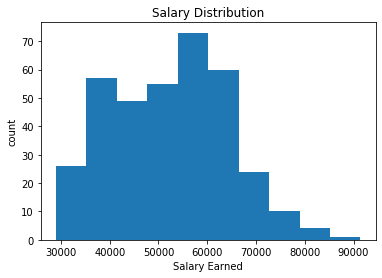

In [93]:
plt.hist(train.salary)
plt.title('Salary Distribution')
plt.xlabel('Salary Earned')
plt.ylabel('count')
plt.show()

### outliers

<function matplotlib.pyplot.show(*args, **kw)>

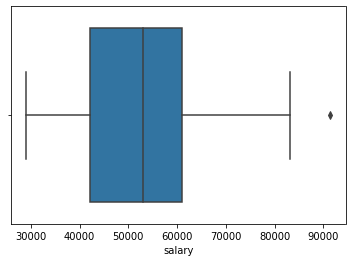

In [94]:
sns.boxplot(train.salary)
plt.show

In [95]:
from scipy.stats import iqr
import numpy as np
my_iqr= iqr(train.salary)

q3= np.percentile(train.salary, 75)
q3+ 1.5 * my_iqr

89388.0

One way of finding outliers is looking for points in out data which are ;

1.5 times the InterQuartile Range greater than the 3rd quartile or below the 1st quartile.

so in our data, anyone earning above 89388 is an outlier.


###  Are the data appropriate for linear regression? Is there anything that needs to be transformed or edited first?

Looking at the data, we see that it is appropriate for linear regression.
From the scatter plot above we see that there is some form of linear relationship between our independent variable (years worked) and our dependent variable (salary).

## 2. Using the statsmodels package and the training data, run a simple linear regression for Salary with one predictor variable: Years Worked.

In [102]:
import statsmodels.formula.api as smf

model= smf.ols(formula= 'salary ~ yearsworked', data= train).fit()

### making sense of the model coefficient

The average salary for someone with no experience is 42377.


### Does the model significantly predict the dependent variable?

In [103]:
preds= model.predict(train.yearsworked)

In [104]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     181.6
Date:                Mon, 03 Feb 2020   Prob (F-statistic):           9.52e-34
Time:                        16:11:25   Log-Likelihood:                -3801.4
No. Observations:                 359   AIC:                             7607.
Df Residuals:                     357   BIC:                             7614.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4.233e+04    897.607     47.164      0.000    4.06e+04    4.41e+04
yearsworked   742.4549     55.094     13.476      0.000     634.104     850.805
==============================================================================
Omnibus:                       31.186   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.947
Skew:                           0.775   Prob(JB):                     9.48e-09
Kurtosis:                       3.262   Cond. No.                         28.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
#r-squared
r_squared= model.rsquared
#p values
pvals= model.pvalues

print(f'r^2 is {r_squared}')
print('-----------------------------------')
print(f'p vals are {pvals[0]}')

r^2 is 0.3371752031178994
-----------------------------------
p vals are 1.956450883536353e-155


(H0)  Null Hypothesis: There's no relationship between salary and years worked.
(H1) Alternative Hypothsis: There is a linear relationship between salary and years worked.

significance level= 0.05

our pvalue is far below our significance level and so the linear relationship between salaries and years worked cannot be due to random chance. Therefore our alternative hypothesis has proven to be true and we reject our null hypothesis.

### What percentage of the variance in employees’ salaries is accounted for by the number of years they have worked?

33.7% of the variance in employee salaries is accounted for by the number of years worked.

### 3. What does the unstandardized coefficient (B or ‘coef’ in statsmodels) tell you about the relationship between Years Worked and Salary?

In [106]:
model.params

Intercept      42334.665436
yearsworked      742.454869
dtype: float64

For every year worked, people get a salary increase of 742 a year.

## 4. What do the 95% confidence intervals [0.025, 0.975] mean?

In [107]:
model.conf_int()

,0,1
Intercept,40569.403506,44099.927366
yearsworked,634.104489,850.805249


It basically tells us that the true mean of the population (salaries in this case), will lie within +-2 standard deviations of our sample mean (this data set). Between 40569 and 44099. Only about 5% of of the times will it not.

## 5. Calculate the expected salary for someone with 12 years’ work experience.

In [108]:
X_12 = pd.DataFrame({'yearsworked': [12]})
y_12= model.predict(X_12)
print(f'someone who has worked 12 years will earn {y_12.iloc[0]}')

someone who has worked 12 years will earn 51244.12386466002


## 6. Calculate the expected salary for someone with 80 years’ work experience. Are there any problems with this prediction? If so, what are they?

In [109]:
X_80 = pd.DataFrame({'yearsworked': [80]})
y_80= model.predict(X_80)
print(f'someone who has worked 80 years will earn {y_80.iloc[0]}')

someone who has worked 80 years will earn 101731.05496240259


The problem with this model is that it assumes that people can work forever. Overtime there will be a diminishing returns on the productivity as people get older, so someone with 80 years of work experience is most likely to be retired.

### 7. We have only looked at the number of years an employee has worked. What other employee characteristics might influence their salary?

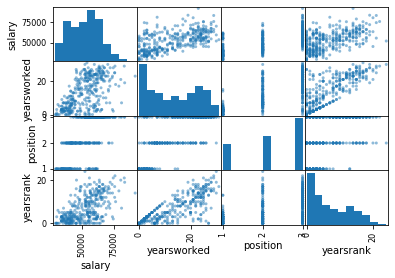

In [110]:
from pandas.plotting import scatter_matrix

scatter_matrix(train[['salary','yearsworked', 'position', 'yearsrank']])
plt.show()

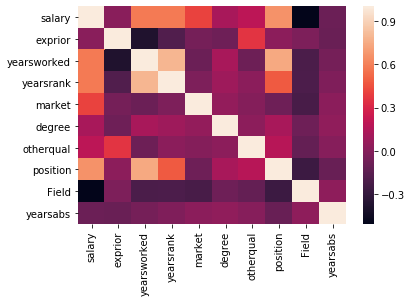

In [111]:
sns.heatmap(train.drop('male', axis=1).corr())

In [112]:
train.corr()['salary']

salary         1.000000
exprior        0.018516
yearsworked    0.580668
yearsrank      0.576945
market         0.406566
degree         0.120654
otherqual      0.194598
position       0.660481
male                NaN
Field         -0.504320
yearsabs      -0.092818
Name: salary, dtype: float64

Other interesting features to look at include;
1. position
2. yearsrank
3. market
4. Field

### Testset

In [113]:
from statsmodels.tools.eval_measures import rmse

test_preds= model.predict(test.yearsworked)

In [114]:
rmse_train= rmse(train.salary, preds)
rmse_test= rmse(test.salary, test_preds)
print(f'The rmse  for the train set is {rmse_train}')
print(f'The rmse  for the test set is {rmse_test}')
print(f'the difference in RMSE between training and testing is {rmse_test- rmse_train}')

The rmse  for the train set is 9602.837216867694
The rmse  for the test set is 10314.70276496445
the difference in RMSE between training and testing is 711.8655480967554


Our model performs better on our training set than on our test set. This means that our model is slightly overfitting. Adding more training examples may help our model to perform better.

## Conclusion

After having analyzed the employee salaries data above, I have found that there is a positive correlation between years worked and the salary earned. This is a suitable relationship for a linear regression.

However, I also found that there is a better predictor which is the position a person works. In the appendix below, I train a model based on the position feature only and it performs better, as it's seen by a lower error.

## Appednix A

In [115]:
model_pos =smf.ols(formula= 'salary ~ position', data= train).fit()
preds= model_pos.predict(train.position)
model_pos.rsquared

0.43623535866185525

This means that roughly 43.6% of the salary increase can be accounted for by the position one is working. The other 56.4% would be from other variables.

In [116]:
pos_preds = model_pos.predict(test.position)
rmse_pos= rmse(test.salary, pos_preds)
rmse_pos

8900.443509107787

We have an error of 8900, which is better compared to the 9602 which we found in the model trained from only the years worked feature.